# LSTM 生成音乐 - 训练
## 引入

In [ ]:
import os
import pickle
from music21 import note, chord

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
from models import get_distinct, create_lookups, prepare_sequences, get_music_list, create_network

keras = tf.keras
tf.compat.v1.experimental.output_all_intermediates(True)

## 环境 & 模型参数

In [2]:
# run params
section = 'compose'
run_id = '0001'
music_name = 'cello'
run_folder = 'run/{}/'.format(section)
run_folder += '_'.join([run_id, music_name])

store_folder = os.path.join(run_folder, 'store')
data_folder = os.path.join('data', music_name)

if not os.path.exists(run_folder):
    os.makedirs(run_folder)
    os.makedirs(os.path.join(run_folder, 'store'))
    os.makedirs(os.path.join(run_folder, 'output'))
    os.makedirs(os.path.join(run_folder, 'weights'))
    os.makedirs(os.path.join(run_folder, 'viz'))

mode = 'load'  # 'build'

# data params
intervals = range(1)
seq_len = 32

# model params
embed_size = 100
rnn_units = 256
use_attention = True


## 数据加载 & 预处理

In [3]:
if mode == 'build':
    music_list, parser = get_music_list(data_folder)
    print(len(music_list), 'files in total')

    notes = []
    durations = []

    for i, file in enumerate(music_list):
        print(i+1, "Parsing %s" % file)
        original_score = parser.parse(file).chordify()

        for interval in intervals:
            score = original_score.transpose(interval)

            notes.extend(['START'] * seq_len)
            durations.extend([0] * seq_len)

            for element in score.flat:
                if isinstance(element, note.Note):
                    if element.isRest:
                        notes.append(str(element.name))
                        durations.append(element.duration.quarterLength)
                    else:
                        notes.append(str(element.nameWithOctave))
                        durations.append(element.duration.quarterLength)

                if isinstance(element, chord.Chord):
                    notes.append(
                        '.'.join(n.nameWithOctave for n in element.pitches))
                    durations.append(element.duration.quarterLength)

    with open(os.path.join(store_folder, 'notes'), 'wb') as f:
        # ['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
        pickle.dump(notes, f)
    with open(os.path.join(store_folder, 'durations'), 'wb') as f:
        pickle.dump(durations, f)
else:
    with open(os.path.join(store_folder, 'notes'), 'rb') as f:
        # ['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
        notes = pickle.load(f)
    with open(os.path.join(store_folder, 'durations'), 'rb') as f:
        durations = pickle.load(f)

In [4]:
# get the distinct sets of notes and durations
note_names, n_notes = get_distinct(notes)
duration_names, n_durations = get_distinct(durations)
distincts = [note_names, n_notes, duration_names, n_durations]

with open(os.path.join(store_folder, 'distincts'), 'wb') as f:
    pickle.dump(distincts, f)

# make the lookup dictionaries for notes and dictionaries and save
note_to_int, int_to_note = create_lookups(note_names)
duration_to_int, int_to_duration = create_lookups(duration_names)
lookups = [note_to_int, int_to_note, duration_to_int, int_to_duration]

with open(os.path.join(store_folder, 'lookups'), 'wb') as f:
    pickle.dump(lookups, f)

print('\nnote_to_int')
note_to_int
print('\nduration_to_int')
duration_to_int


note_to_int


{'A2': 0,
 'A2.A3': 1,
 'A2.B-3': 2,
 'A2.B2': 3,
 'A2.C3': 4,
 'A2.D3': 5,
 'A2.E-3': 6,
 'A2.E3': 7,
 'A2.E3.A3': 8,
 'A2.E3.C#4': 9,
 'A2.E3.C#4.A4': 10,
 'A2.E3.C#4.E4': 11,
 'A2.E3.C#4.G#4': 12,
 'A2.E3.C4': 13,
 'A2.E3.D4': 14,
 'A2.F#3': 15,
 'A2.F#3.C4': 16,
 'A2.F#3.D4': 17,
 'A2.F#3.D4.A4': 18,
 'A2.F#3.D4.E4': 19,
 'A2.F#3.D4.F#4': 20,
 'A2.F#4': 21,
 'A2.F3': 22,
 'A2.F3.C4': 23,
 'A2.F3.D4': 24,
 'A2.F3.D4.A4': 25,
 'A2.G3': 26,
 'A2.G3.C#4': 27,
 'A2.G3.D4': 28,
 'A3': 29,
 'A3.B-3': 30,
 'A3.B3': 31,
 'A3.B3.C#4': 32,
 'A3.B3.C#4.D4': 33,
 'A3.B3.C4': 34,
 'A3.C#4': 35,
 'A3.C#4.E4': 36,
 'A3.C4': 37,
 'A3.D4': 38,
 'A3.E4': 39,
 'A3.E4.F#4': 40,
 'A3.E4.G4': 41,
 'A3.F#4': 42,
 'A3.F#4.G4': 43,
 'A3.F4': 44,
 'A3.G4': 45,
 'A4': 46,
 'A4.B4': 47,
 'B-2': 48,
 'B-2.A3': 49,
 'B-2.B-3': 50,
 'B-2.C3': 51,
 'B-2.D3': 52,
 'B-2.D3.A3': 53,
 'B-2.D3.E-3.G#3': 54,
 'B-2.D3.G#3': 55,
 'B-2.E-3': 56,
 'B-2.E3': 57,
 'B-2.E3.D4': 58,
 'B-2.F#3.C#4.E4': 59,
 'B-2.F3': 60,
 'B-2.F


duration_to_int


{0: 0,
 Fraction(1, 12): 1,
 Fraction(1, 6): 2,
 0.25: 3,
 Fraction(1, 3): 4,
 0.5: 5,
 Fraction(2, 3): 6,
 0.75: 7,
 1.0: 8,
 1.25: 9,
 Fraction(4, 3): 10,
 1.5: 11,
 1.75: 12,
 2.0: 13,
 2.5: 14,
 3.0: 15,
 4.0: 16}

In [5]:
network_input, network_output = prepare_sequences(notes, durations, lookups, distincts, seq_len)

print('pitch input')
print(network_input[0][0])
print('duration input')
print(network_input[1][0])
print('pitch output')
print(network_output[0][0])
print('duration output')
print(network_output[1][0])

pitch input
[469 469 469 469 469 469 469 469 469 469 469 469 469 469 469 469 469 469
 469 469 469 469 469 469 469 469 469 469 469 469 469 469]
duration input
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
pitch output
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

## 构建模型

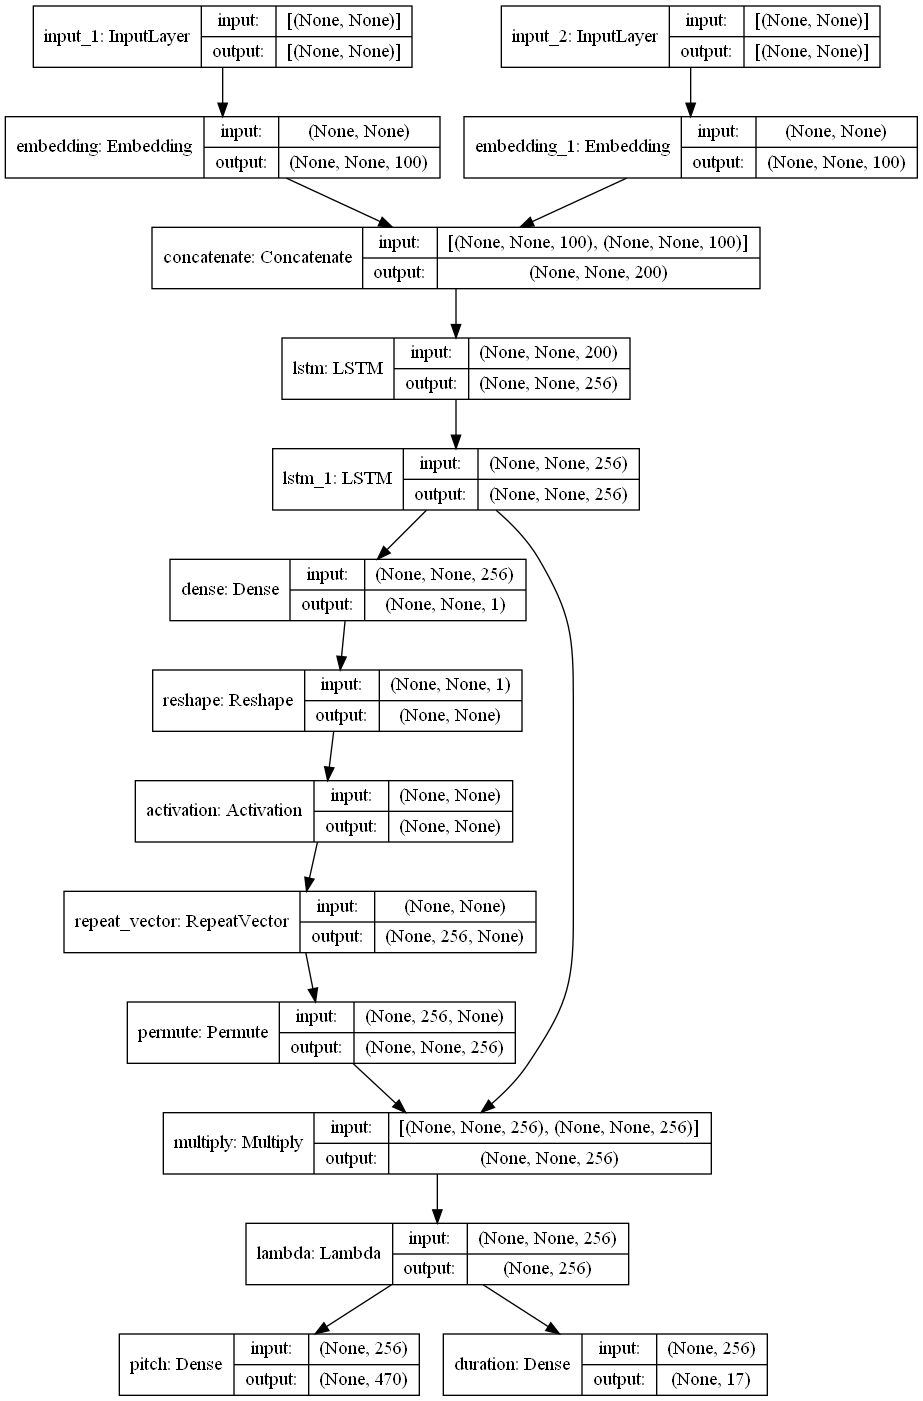

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    47000       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    1700        input_2[0][0]                    
______________________________________________________________________________________________

In [6]:
model, att_model = create_network(
    n_notes, n_durations, embed_size, rnn_units, use_attention)
keras.utils.plot_model(model, to_file=os.path.join(
    run_folder, 'viz/model.png'), show_shapes=True, show_layer_names=True)
model.summary()


## 训练模型

In [ ]:
weights_folder = os.path.join(run_folder, 'weights')

checkpoint1 = keras.callbacks.ModelCheckpoint(
    os.path.join(weights_folder,
                 "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

checkpoint2 = keras.callbacks.ModelCheckpoint(
    os.path.join(weights_folder, "weights.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='loss', restore_best_weights=True, patience=10
)


callbacks_list = [
    checkpoint1, checkpoint2, early_stopping
]

model.save_weights(os.path.join(weights_folder, "weights.h5"))
model.fit(network_input, network_output, epochs=2000000, batch_size=32, validation_split=0.2, callbacks=callbacks_list, shuffle=True)